In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qutip import *
from qutip.ui.progressbar import TextProgressBar
%matplotlib inline
from qutip.ipynbtools import version_table
#version_table()

### Quick Test

In [2]:
import numpy as np
from scipy.linalg import sqrtm, eigvals
from qutip import *
from tqdm import tqdm

# Function to calculate the entanglement of formation given the concurrence
def entanglement_of_formation(concurrence):
    if concurrence <= 0:
        return 0
    elif concurrence >= 1:
        return 1
    h = lambda x: -x * np.log2(x + 1e-12) - (1 - x) * np.log2(1 - x + 1e-12)  # Binary entropy function
    sqrt_term = np.sqrt(1 - concurrence**2)
    return h((1 + max(0, sqrt_term)) / 2)  # Calculate entanglement of formation

# Function to calculate the concurrence of a density matrix
def calculate_concurrence(rho):
    rho = rho.full().astype(np.complex128)
    R = sqrtm(sqrtm(rho) @ rho.conj().T @ sqrtm(rho))
    eigvals_R = np.sort(np.real(eigvals(R)))[::-1]
    return max(0, eigvals_R[0] - sum(eigvals_R[1:]))

# Function to calculate the quantum discord of a two-qubit state
def quantum_discord(rho_AB):
    eigvals, eigvecs = rho_AB.eigenstates()
    ancilla_dim = 2
    psi_purified = sum(np.sqrt(eigvals[i]) * tensor(eigvecs[i], basis(ancilla_dim, 0)) for i in range(len(eigvals)))
    rho_AC = psi_purified.ptrace([0, 2])
    rho_B = rho_AB.ptrace([1])
    S_rho_B = entropy_vn(rho_B, base=2)
    S_rho_AB = entropy_vn(rho_AB, base=2)
    concurrence_rho_AC = calculate_concurrence(rho_AC)
    E_C = entanglement_of_formation(concurrence_rho_AC)
    return max(0, S_rho_B - S_rho_AB + E_C)

# Example Bell state density matrix
bell_state = (tensor(basis(2, 0), basis(2, 0)) + tensor(basis(2, 1), basis(2, 1))).unit()
rho_bell = bell_state * bell_state.dag()

# Example maximally mixed state
rho_mixed = qeye(4) / 4
rho_mixed.dims = [[2, 2], [2, 2]]

# Original density matrix
data = [
    [0.31478817, 0.05239977, 0.14084707, 0.16087211],
    [0.05239977, 0.11181522, 0.08096762, 0.03145797],
    [0.14084707, 0.08096762, 0.37352824, 0.17620866],
    [0.16087211, 0.03145797, 0.17620866, 0.19986838]
]
rho_AB = Qobj(data, dims=[[2, 2], [2, 2]])

states = [("Bell State", rho_bell), ("Maximally Mixed State", rho_mixed), ("Original Density Matrix", rho_AB)]

for name, state in tqdm(states, desc="Calculating Quantum Discord"):
    discord = quantum_discord(state)
    print(f"Quantum Discord for {name}: {discord}")


Calculating Quantum Discord: 100%|██████████| 3/3 [00:00<00:00, 175.30it/s]

Quantum Discord for Bell State: 0.9999999999985936
Quantum Discord for Maximally Mixed State: 0
Quantum Discord for Original Density Matrix: 0


# For Random Density Matrices (rank no bar)

Random Density Matrices: 100%|██████████| 1000/1000 [00:02<00:00, 380.82it/s]


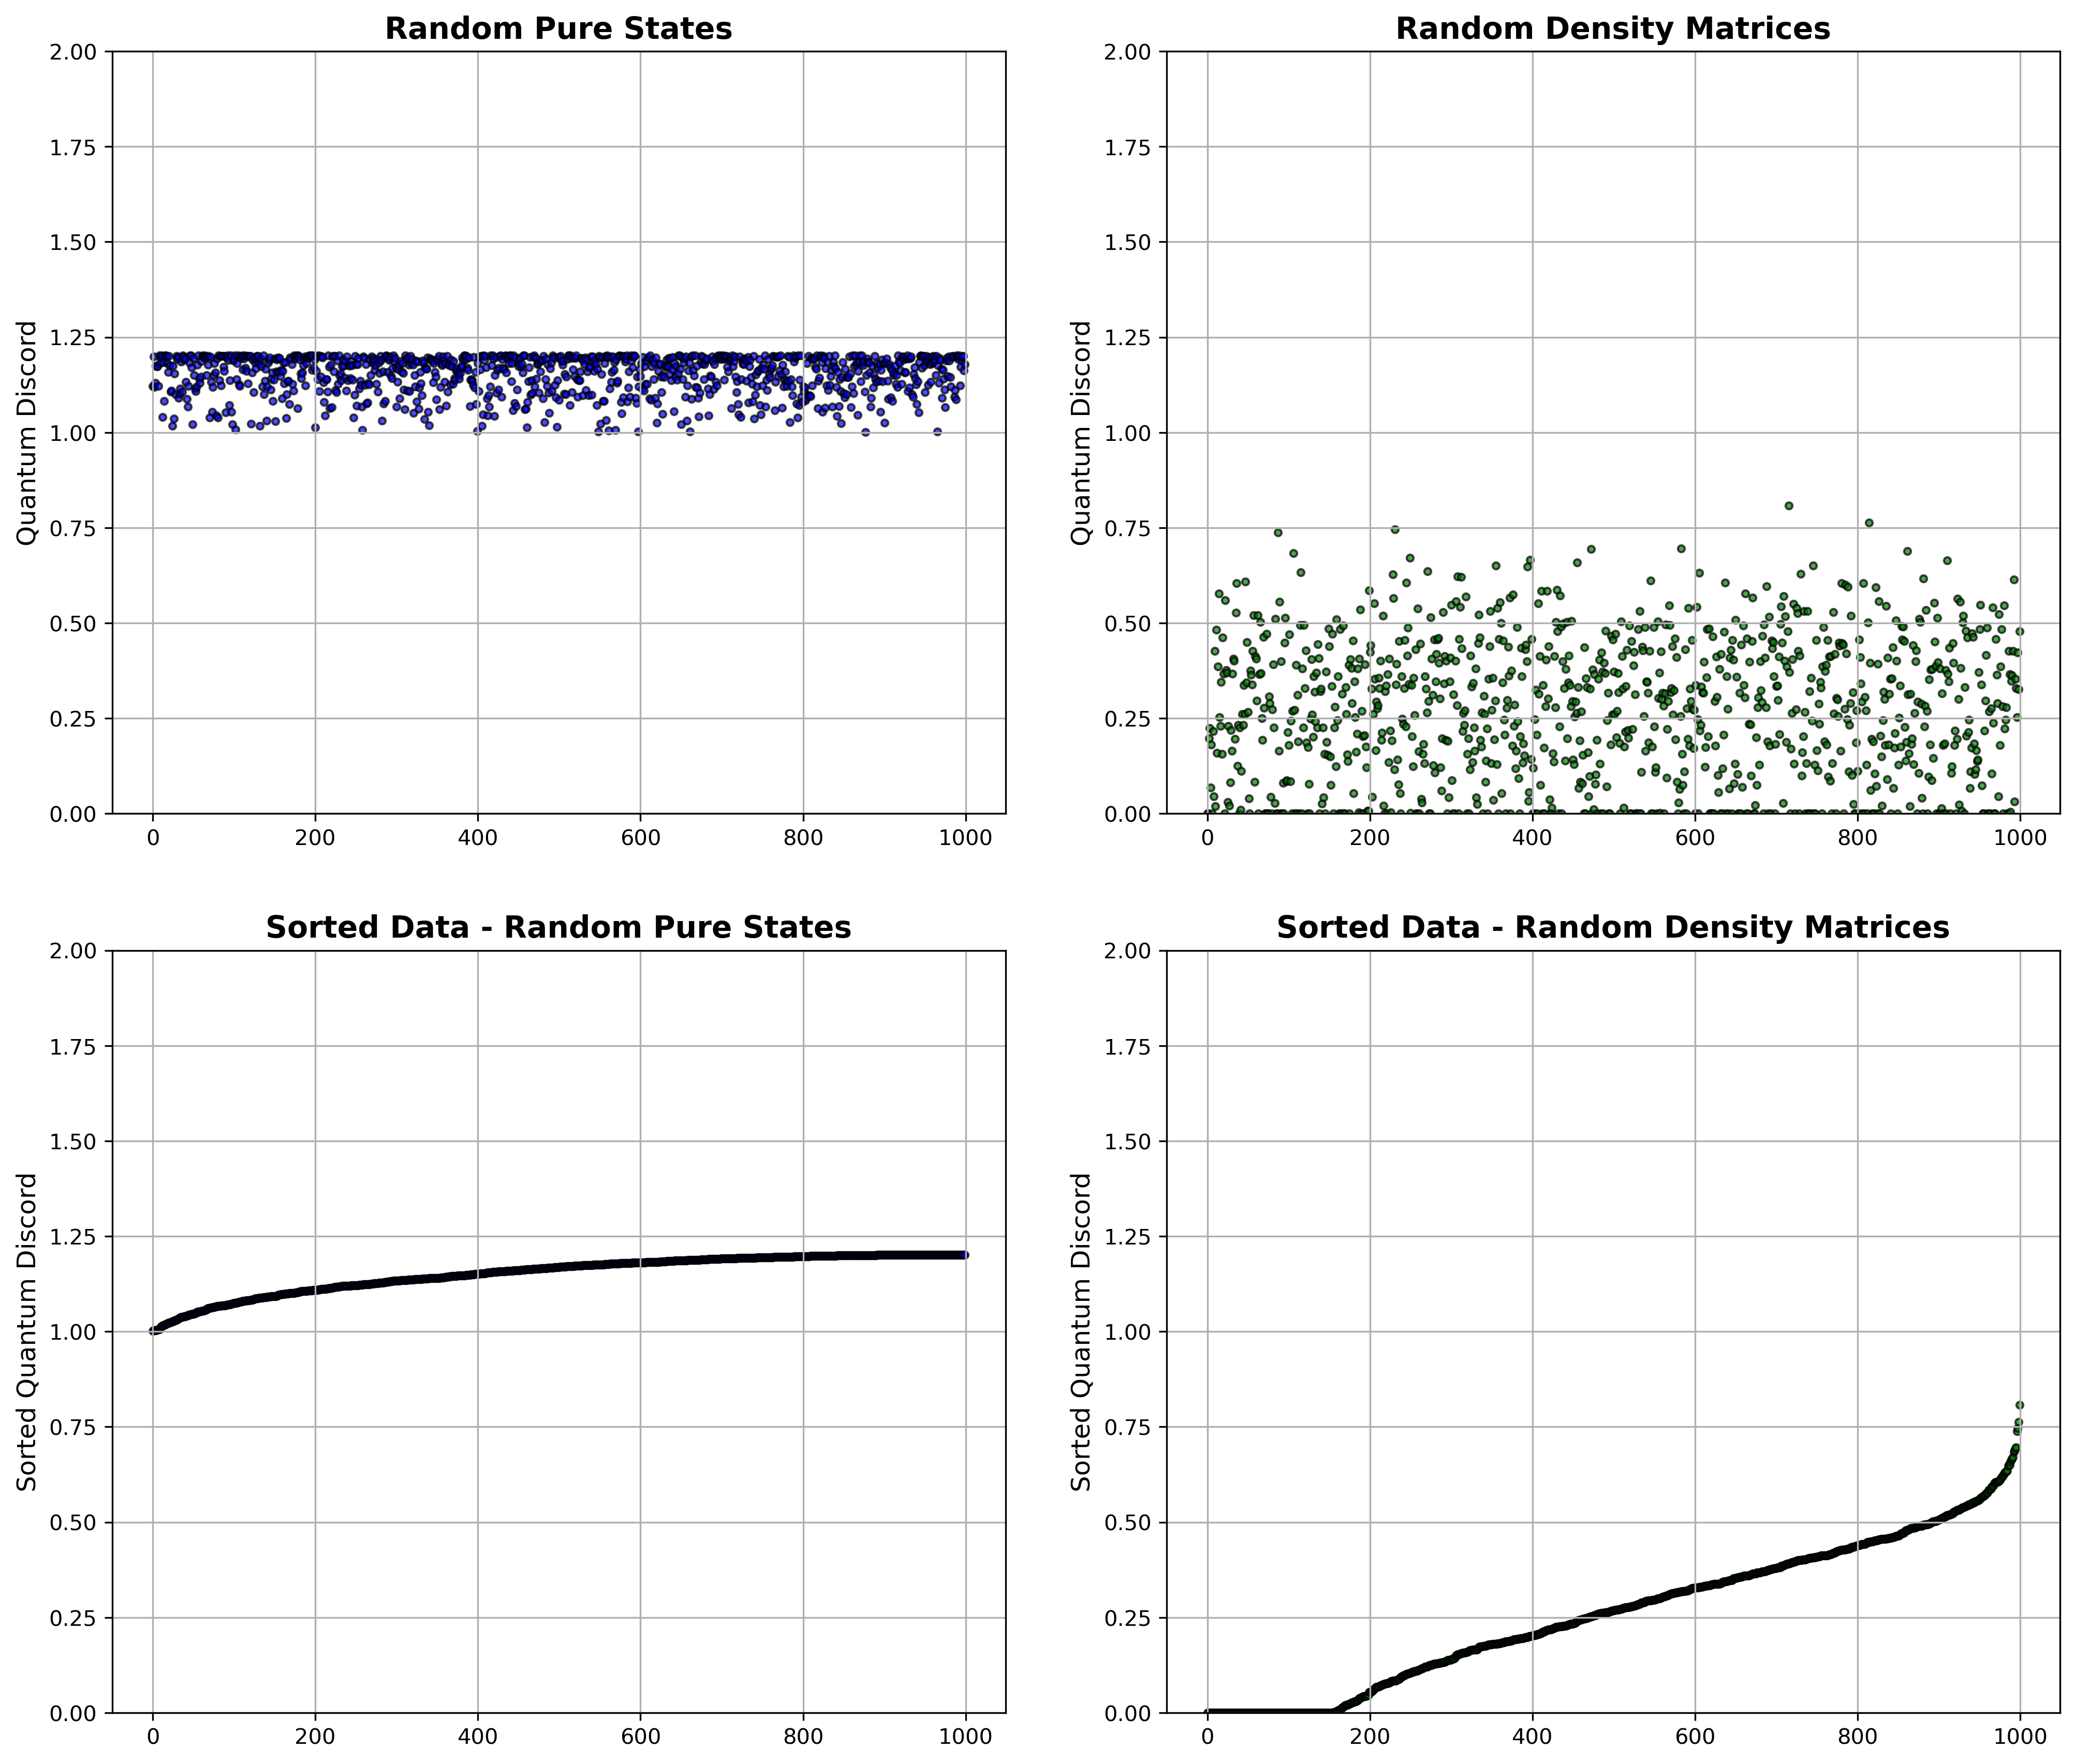

In [3]:
import numpy as np
from scipy.linalg import sqrtm, eigvals
from qutip import *
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.stats import unitary_group

def entanglement_of_formation(concurrence):
    if concurrence <= 0:
        return 0
    elif concurrence >= 1:
        return 1
    h = lambda x: -x * np.log2(x + 1e-12) - (1 - x) * np.log2(1 - x + 1e-12)  # Binary entropy function
    sqrt_term = np.sqrt(1 - concurrence**2)
    return h((1 + max(0, sqrt_term)) / 2)  # Calculate entanglement of formation

def calculate_concurrence(rho):
    rho = rho.full().astype(np.complex128)
    try:
        R = sqrtm(sqrtm(rho) @ rho.conj().T @ sqrtm(rho))
        eigvals_R = np.sort(np.real(eigvals(R)))[::-1]
        return max(0, eigvals_R[0] - sum(eigvals_R[1:]))
    except ValueError as e:
        return np.nan

def quantum_discord(rho_AB):
    try:
        eigvals, eigvecs = rho_AB.eigenstates()
        ancilla_dim = 2
        psi_purified = sum(np.sqrt(max(0, eigvals[i])) * tensor(eigvecs[i], basis(ancilla_dim, 0)) for i in range(len(eigvals)))
        rho_AC = psi_purified.ptrace([0, 2])
        rho_B = rho_AB.ptrace([1])
        S_rho_B = entropy_vn(rho_B, base=2)
        S_rho_AB = entropy_vn(rho_AB, base=2)
        concurrence_rho_AC = calculate_concurrence(rho_AC)
        E_C = entanglement_of_formation(concurrence_rho_AC)
        return max(0, S_rho_B - S_rho_AB + E_C)
    except ValueError as e:
        return np.nan

# Generate 1000 random pure states and calculate their quantum discord
quantum_discord_pure = []
for _ in tqdm(range(1000), desc="Random Pure States"):
    psi = np.zeros(4)
    psi[0] = 1.
    random_psi = unitary_group.rvs(4) @ psi
    random_rho_pure = np.outer(random_psi, np.conjugate(random_psi))
    rho_pure_qobj = Qobj(random_rho_pure, dims=[[2, 2], [2, 2]])
    discord_pure = quantum_discord(rho_pure_qobj)
    if not np.isnan(discord_pure):
        quantum_discord_pure.append(discord_pure)

# Generate 1000 random rank-2 density matrices and calculate their quantum discord
quantum_discord_density = []
for _ in tqdm(range(1000), desc="Random Density Matrices"):
    gin = np.random.rand(4, 4) + 1j * np.random.rand(4, 4)
    gue = gin + np.conjugate(np.transpose(gin))
    if np.min(np.linalg.eigh(gue)[0]) < 0:
        gue = -np.min(np.linalg.eigh(gue)[0]) * np.eye(4) + gue
    gue = gue / np.trace(gue)
    random_rho_density = gue
    if np.abs(np.trace(random_rho_density) - 1) > 1.e-14:
        raise ValueError("Trace is not 1!")
    rho_density_qobj = Qobj(random_rho_density, dims=[[2, 2], [2, 2]])
    discord_density = quantum_discord(rho_density_qobj)
    if not np.isnan(discord_density):
        quantum_discord_density.append(discord_density)

# Create scatter and sorted plots
fig, axs = plt.subplots(2, 2, figsize=(14, 12), dpi=300)

# Scatter plot for random pure states
axs[0, 0].scatter(np.arange(len(quantum_discord_pure)), quantum_discord_pure, s=10, color='blue', alpha=0.7, edgecolors='k')
axs[0, 0].set_title('Random Pure States', fontsize=14, fontweight='bold')
axs[0, 0].set_ylim([0, 2])
axs[0, 0].set_ylabel('Quantum Discord', fontsize=12)
axs[0, 0].tick_params(axis='both', which='major', labelsize=10)
axs[0, 0].grid(True)

# Scatter plot for random density matrices
axs[0, 1].scatter(np.arange(len(quantum_discord_density)), quantum_discord_density, s=10, color='green', alpha=0.7, edgecolors='k')
axs[0, 1].set_title('Random Density Matrices', fontsize=14, fontweight='bold')
axs[0, 1].set_ylim([0, 2])
axs[0, 1].set_ylabel('Quantum Discord', fontsize=12)
axs[0, 1].tick_params(axis='both', which='major', labelsize=10)
axs[0, 1].grid(True)

# Sorted scatter plot for random pure states
axs[1, 0].scatter(np.arange(len(quantum_discord_pure)), np.sort(quantum_discord_pure), s=10, color='blue', alpha=0.7, edgecolors='k')
axs[1, 0].set_title('Sorted Data - Random Pure States', fontsize=14, fontweight='bold')
axs[1, 0].set_ylim([0, 2])
axs[1, 0].set_ylabel('Sorted Quantum Discord', fontsize=12)
axs[1, 0].tick_params(axis='both', which='major', labelsize=10)
axs[1, 0].grid(True)

# Sorted scatter plot for random density matrices
axs[1, 1].scatter(np.arange(len(quantum_discord_density)), np.sort(quantum_discord_density), s=10, color='green', alpha=0.7, edgecolors='k')
axs[1, 1].set_title('Sorted Data - Random Density Matrices', fontsize=14, fontweight='bold')
axs[1, 1].set_ylim([0, 2])
axs[1, 1].set_ylabel('Sorted Quantum Discord', fontsize=12)
axs[1, 1].tick_params(axis='both', which='major', labelsize=10)
axs[1, 1].grid(True)

plt.tight_layout(pad=3.0)
plt.show()


Random Pure States:   0%|          | 0/1000 [00:00<?, ?it/s]

Random Density Matrices: 100%|██████████| 1000/1000 [00:02<00:00, 378.59it/s]


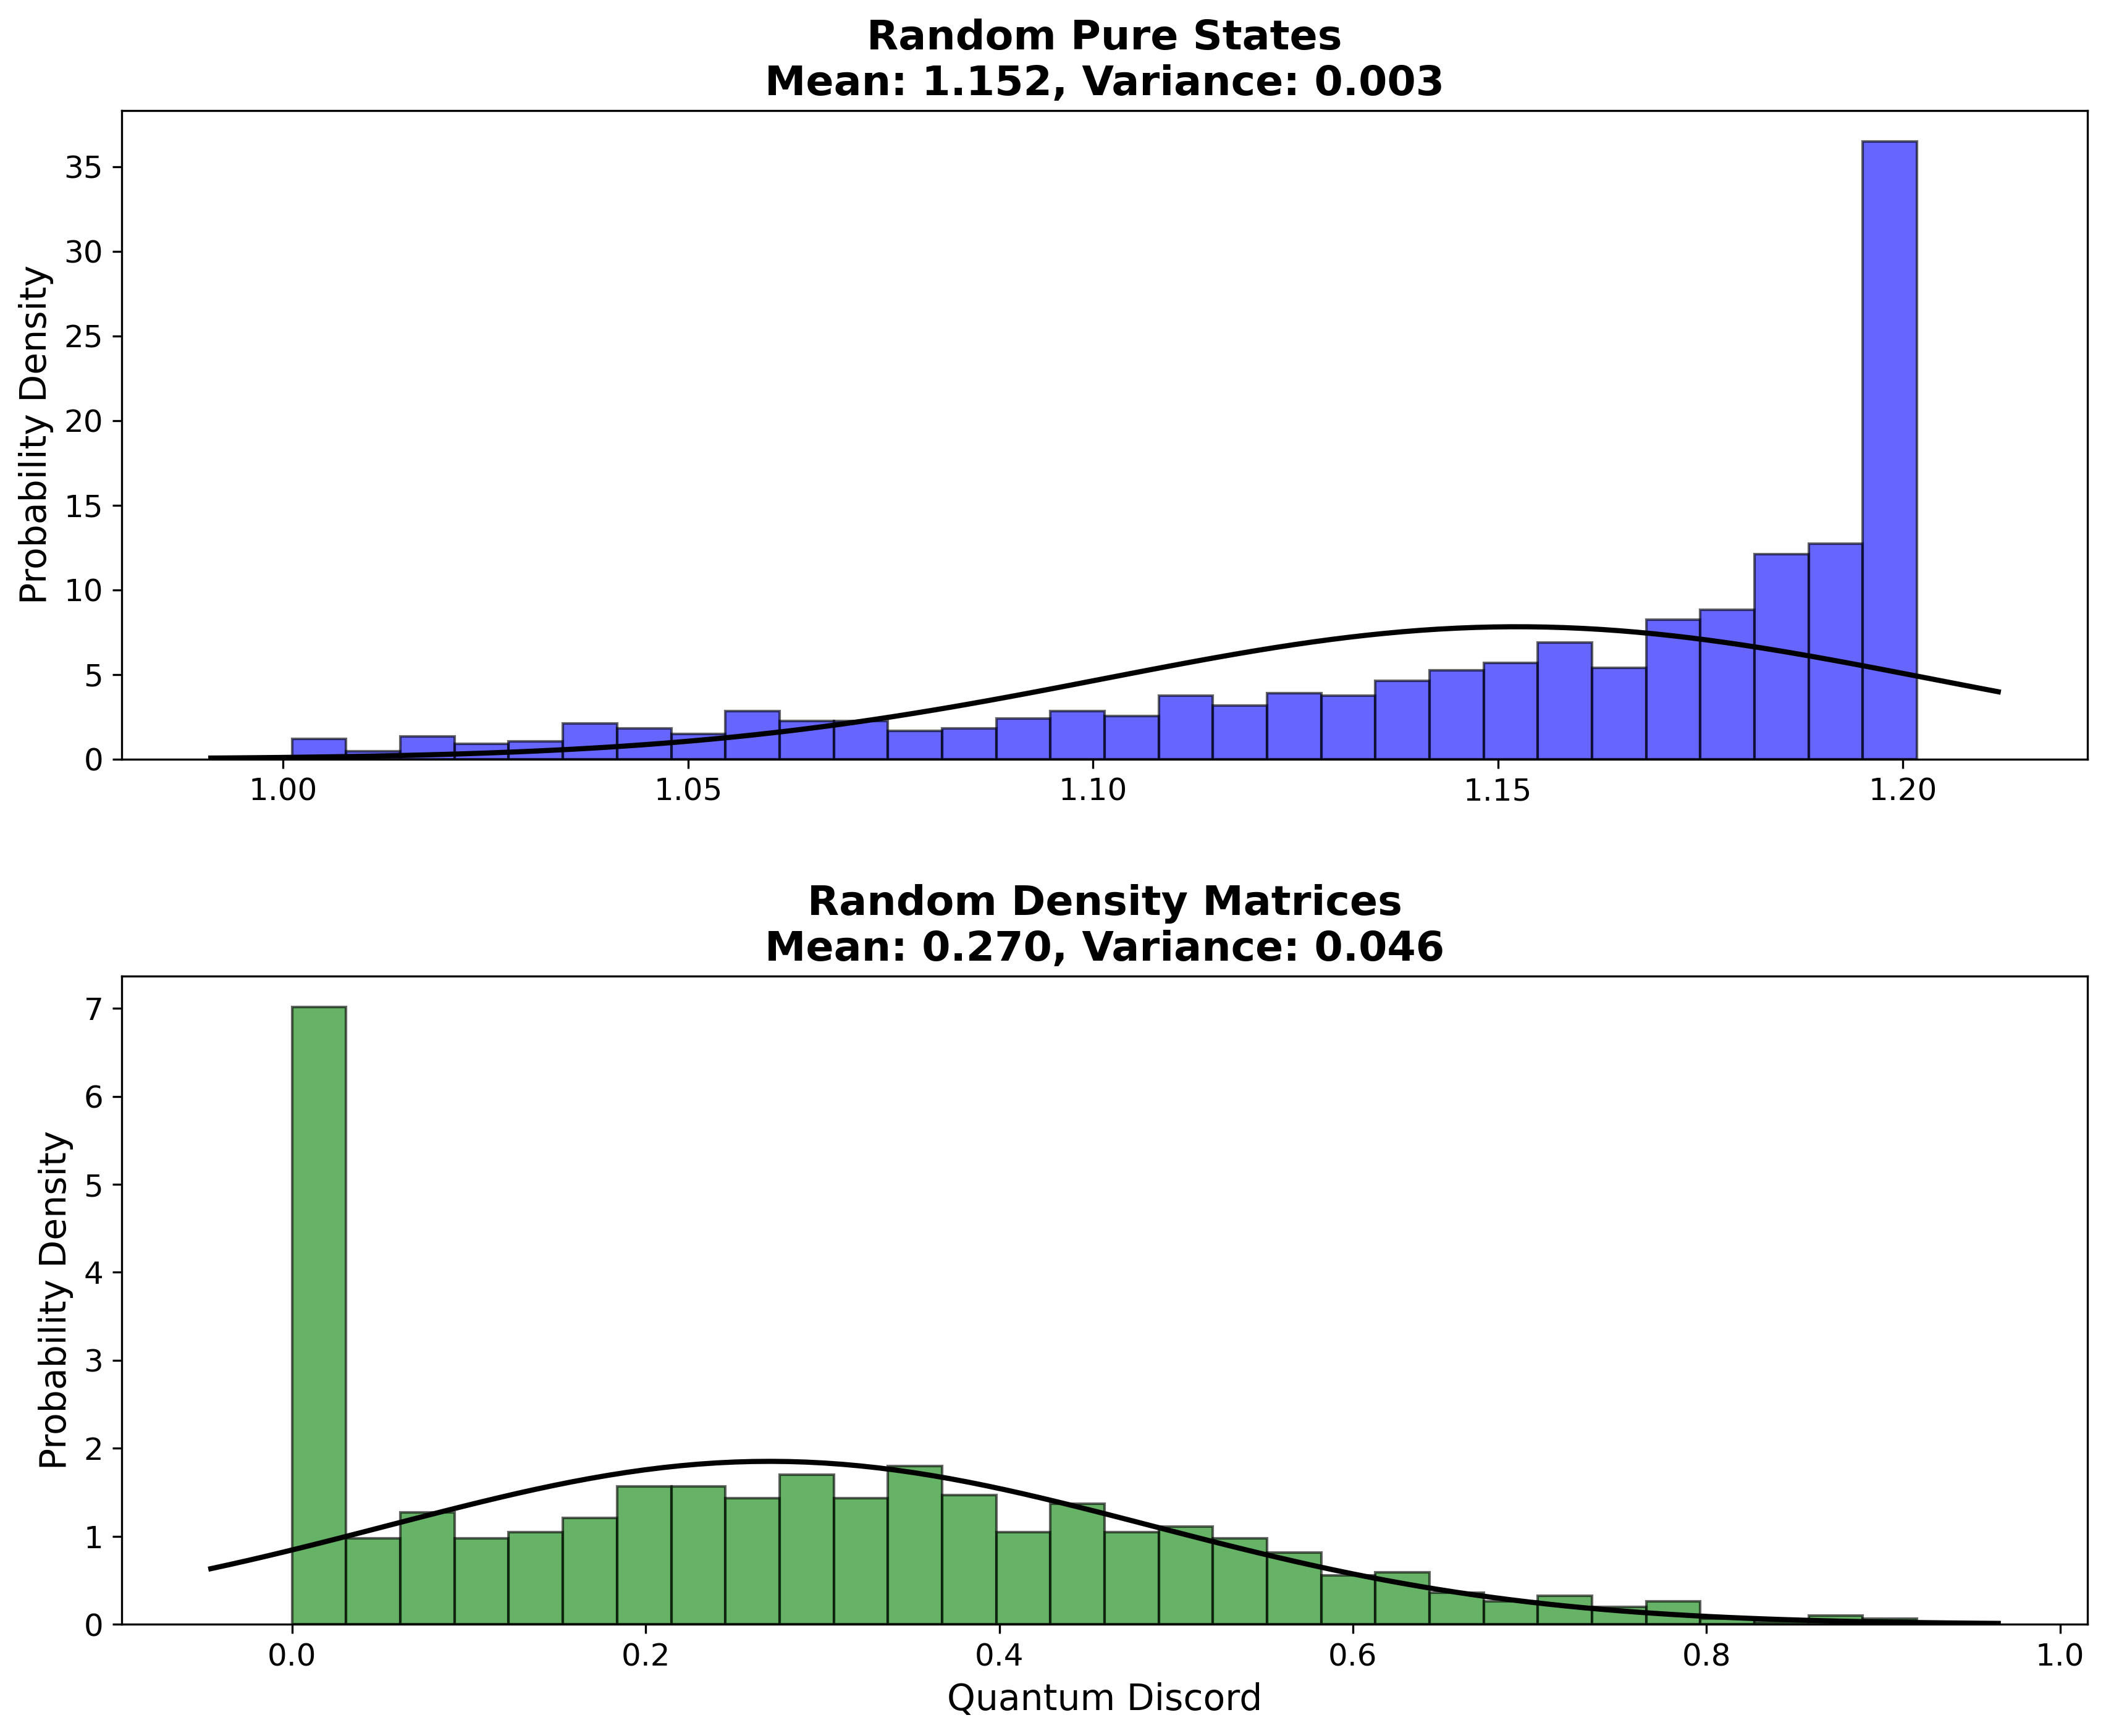

In [14]:
import numpy as np
from scipy.linalg import sqrtm, eigvals
from qutip import *
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.stats import unitary_group, norm

def entanglement_of_formation(concurrence):
    if concurrence <= 0:
        return 0
    elif concurrence >= 1:
        return 1
    h = lambda x: -x * np.log2(x + 1e-12) - (1 - x) * np.log2(1 - x + 1e-12)  # Binary entropy function
    sqrt_term = np.sqrt(1 - concurrence**2)
    return h((1 + max(0, sqrt_term)) / 2)  # Calculate entanglement of formation

def calculate_concurrence(rho):
    rho = rho.full().astype(np.complex128)
    try:
        R = sqrtm(sqrtm(rho) @ rho.conj().T @ sqrtm(rho))
        eigvals_R = np.sort(np.real(eigvals(R)))[::-1]
        return max(0, eigvals_R[0] - sum(eigvals_R[1:]))
    except ValueError as e:
        return np.nan

def quantum_discord(rho_AB):
    try:
        eigvals, eigvecs = rho_AB.eigenstates()
        ancilla_dim = 2
        psi_purified = sum(np.sqrt(max(0, eigvals[i])) * tensor(eigvecs[i], basis(ancilla_dim, 0)) for i in range(len(eigvals)))
        rho_AC = psi_purified.ptrace([0, 2])
        rho_B = rho_AB.ptrace([1])
        S_rho_B = entropy_vn(rho_B, base=2)
        S_rho_AB = entropy_vn(rho_AB, base=2)
        concurrence_rho_AC = calculate_concurrence(rho_AC)
        E_C = entanglement_of_formation(concurrence_rho_AC)
        return max(0, S_rho_B - S_rho_AB + E_C)
    except ValueError as e:
        return np.nan

# Generate 1000 random pure states and calculate their quantum discord
quantum_discord_pure = []
for _ in tqdm(range(1000), desc="Random Pure States"):
    psi = np.zeros(4)
    psi[0] = 1.
    random_psi = unitary_group.rvs(4) @ psi
    random_rho_pure = np.outer(random_psi, np.conjugate(random_psi))
    rho_pure_qobj = Qobj(random_rho_pure, dims=[[2, 2], [2, 2]])
    discord_pure = quantum_discord(rho_pure_qobj)
    if not np.isnan(discord_pure):
        quantum_discord_pure.append(discord_pure)

# Generate 1000 random density matrices and calculate their quantum discord
quantum_discord_density = []
for _ in tqdm(range(1000), desc="Random Density Matrices"):
    gin = np.random.normal(size=(4, 4)) + 1j * np.random.normal(size=(4, 4))
    gue = gin @ gin.conj().T
    gue = gue / np.trace(gue)
    random_rho_density = gue
    if np.abs(np.trace(random_rho_density) - 1) > 1.e-14:
        raise ValueError("Trace is not 1!")
    rho_density_qobj = Qobj(random_rho_density, dims=[[2, 2], [2, 2]])
    discord_density = quantum_discord(rho_density_qobj)
    if not np.isnan(discord_density):
        quantum_discord_density.append(discord_density)

# Calculate mean and variance
mean_discord_pure = np.mean(quantum_discord_pure)
var_discord_pure = np.var(quantum_discord_pure)
mean_discord_density = np.mean(quantum_discord_density)
var_discord_density = np.var(quantum_discord_density)

# Create histograms and overlay Gaussian distribution
fig, axs = plt.subplots(2, 1, figsize=(12, 10), dpi=300)

# Histogram for random pure states
axs[0].hist(quantum_discord_pure, bins=30, density=True, alpha=0.6, color='blue', edgecolor='black')
xmin, xmax = axs[0].get_xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mean_discord_pure, np.sqrt(var_discord_pure))
axs[0].plot(x, p, 'k', linewidth=2)
axs[0].set_title(f'Random Pure States\nMean: {mean_discord_pure:.3f}, Variance: {var_discord_pure:.3f}', fontsize=16, fontweight='bold')
axs[0].set_ylabel('Probability Density', fontsize=14)
axs[0].tick_params(axis='both', which='major', labelsize=12)
#axs[0].grid(True, linestyle='--', linewidth=0.5)

# Histogram for random density matrices
axs[1].hist(quantum_discord_density, bins=30, density=True, alpha=0.6, color='green', edgecolor='black')
xmin, xmax = axs[1].get_xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mean_discord_density, np.sqrt(var_discord_density))
axs[1].plot(x, p, 'k', linewidth=2)
axs[1].set_title(f'Random Density Matrices\nMean: {mean_discord_density:.3f}, Variance: {var_discord_density:.3f}', fontsize=16, fontweight='bold')
axs[1].set_xlabel('Quantum Discord', fontsize=14)
axs[1].set_ylabel('Probability Density', fontsize=14)
axs[1].tick_params(axis='both', which='major', labelsize=12)
#axs[1].grid(True, linestyle='--', linewidth=0.5)

plt.tight_layout(pad=3.0)
plt.show()


# For Rank-2 Density Matrices

Random Pure States:   0%|          | 0/1000 [00:00<?, ?it/s]

Random Density Matrices: 100%|██████████| 1000/1000 [00:02<00:00, 383.87it/s]


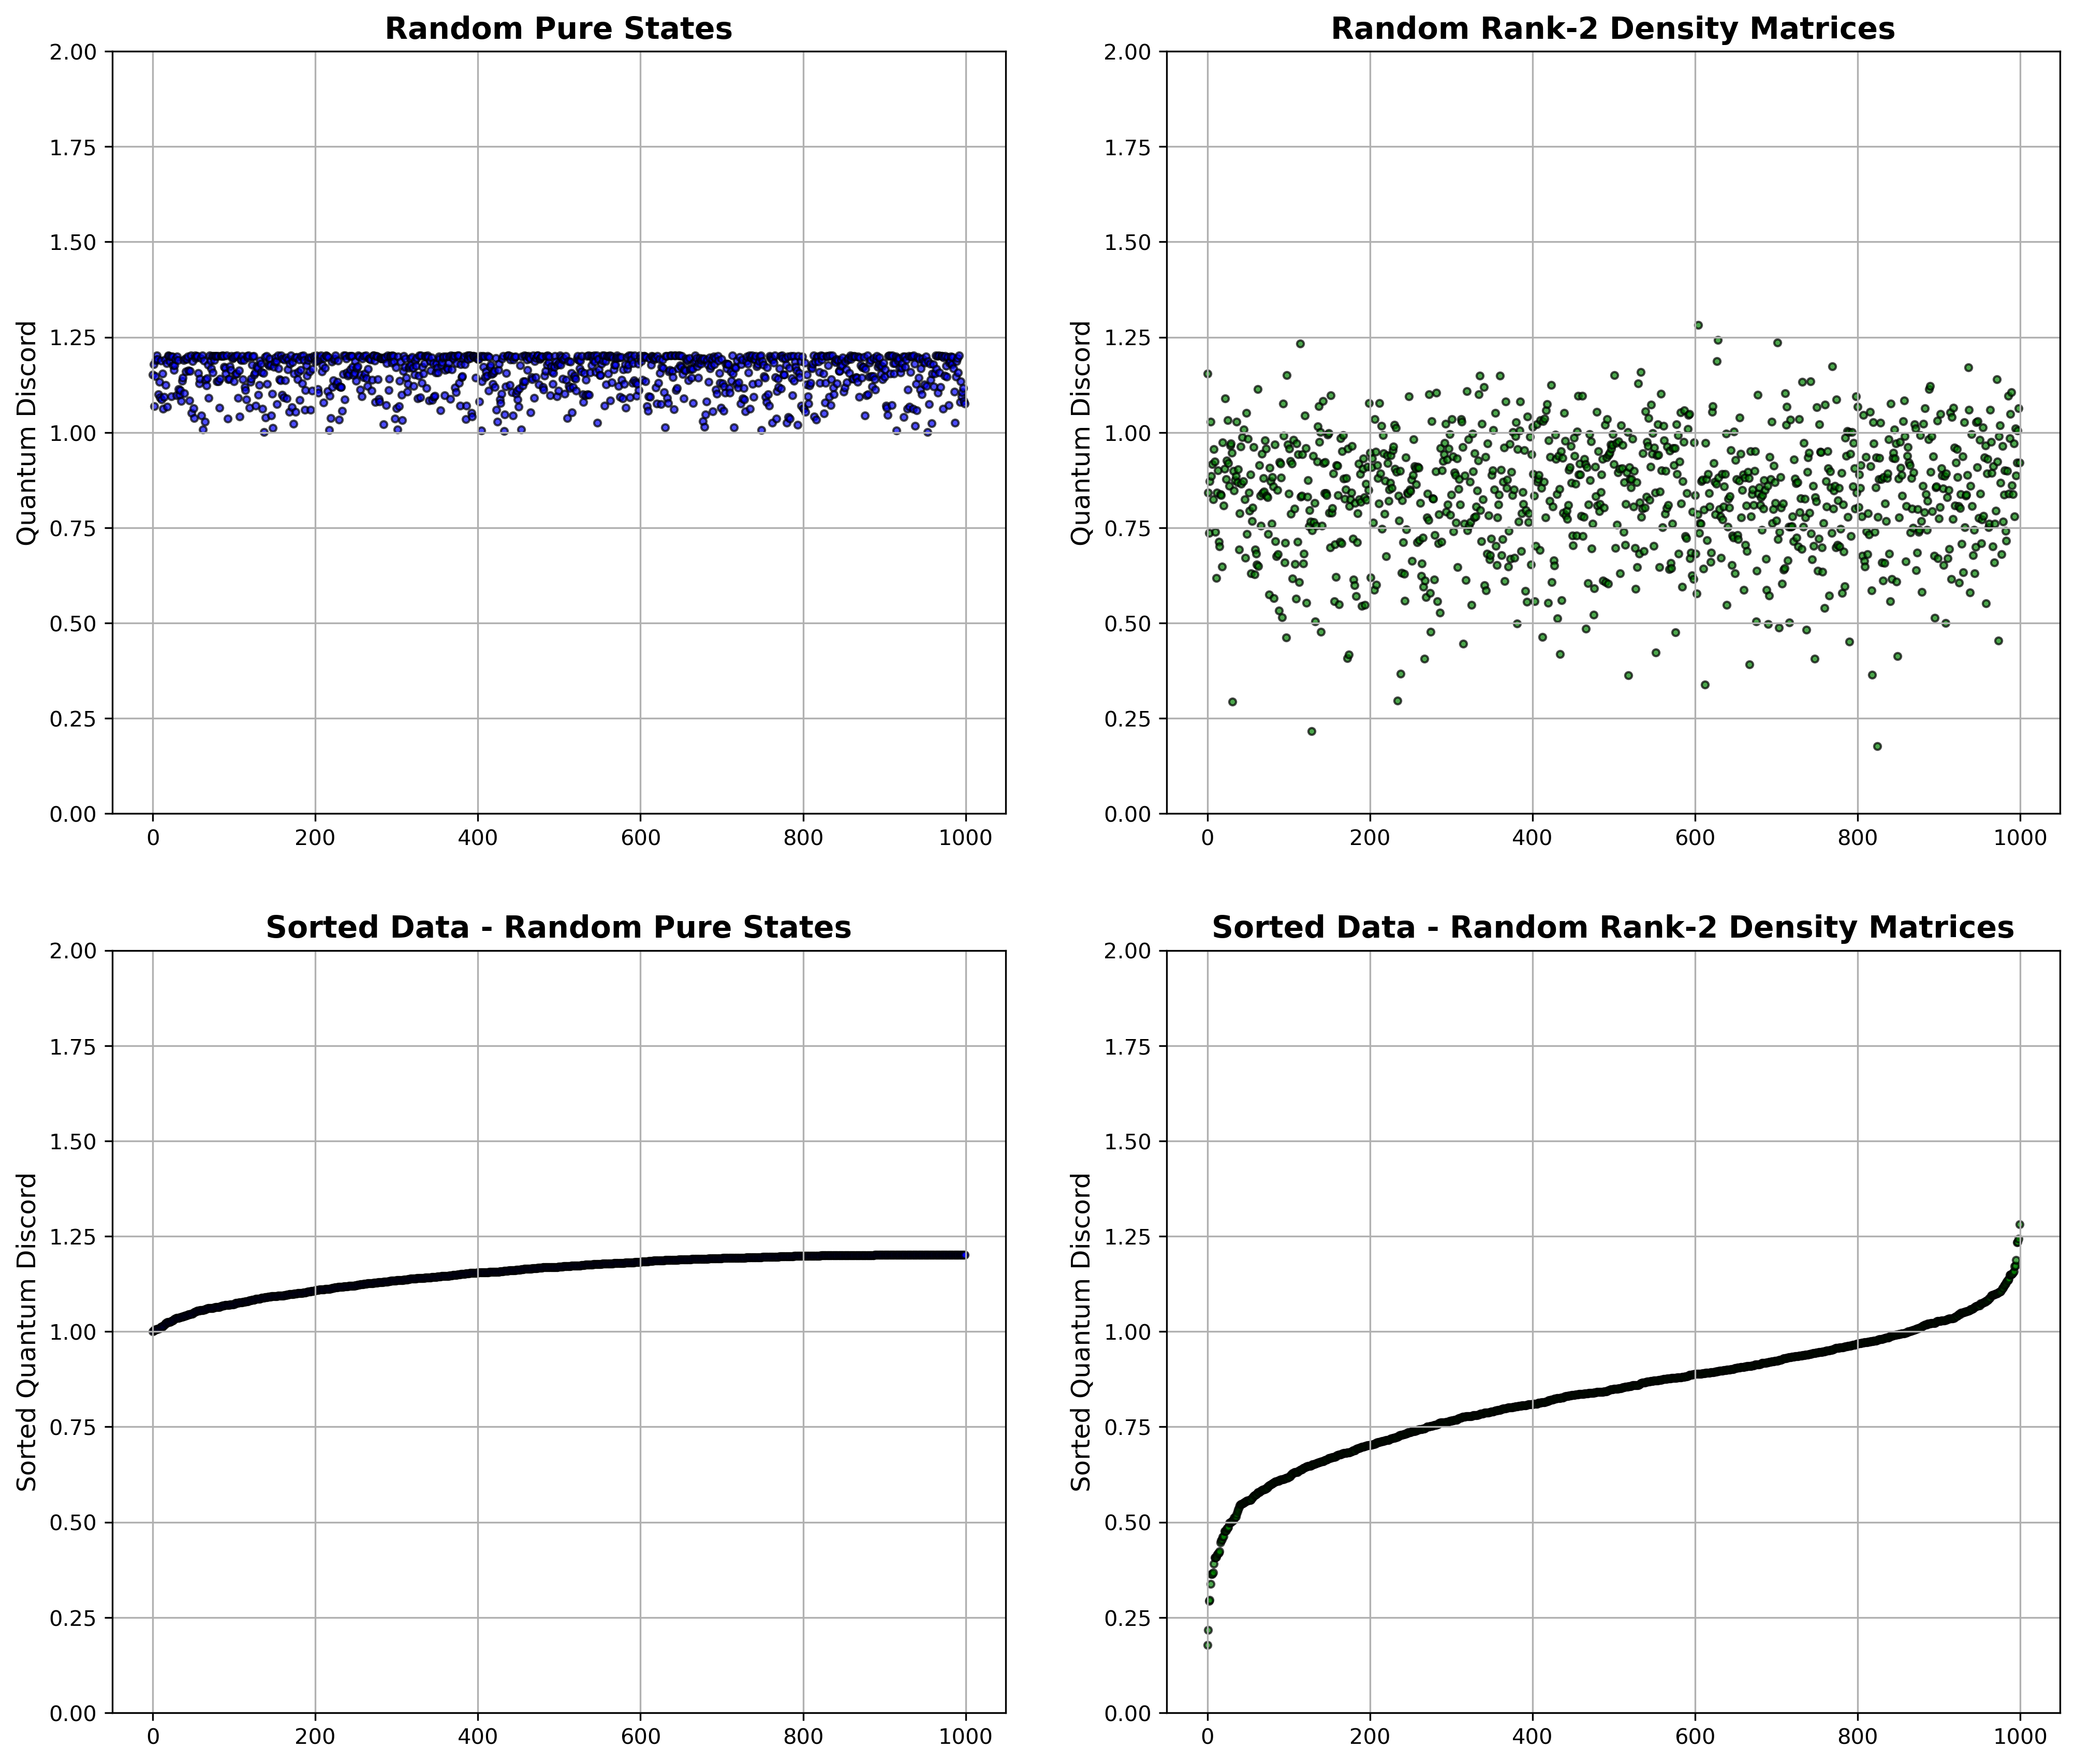

In [6]:
import numpy as np
from scipy.linalg import sqrtm, eigvals
from qutip import *
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.stats import unitary_group

def entanglement_of_formation(concurrence):
    if concurrence <= 0:
        return 0
    elif concurrence >= 1:
        return 1
    h = lambda x: -x * np.log2(x + 1e-12) - (1 - x) * np.log2(1 - x + 1e-12)  # Binary entropy function
    sqrt_term = np.sqrt(1 - concurrence**2)
    return h((1 + max(0, sqrt_term)) / 2)  # Calculate entanglement of formation

def calculate_concurrence(rho):
    rho = rho.full().astype(np.complex128)
    try:
        R = sqrtm(sqrtm(rho) @ rho.conj().T @ sqrtm(rho))
        eigvals_R = np.sort(np.real(eigvals(R)))[::-1]
        return max(0, eigvals_R[0] - sum(eigvals_R[1:]))
    except ValueError as e:
        return np.nan

def quantum_discord(rho_AB):
    try:
        eigvals, eigvecs = rho_AB.eigenstates()
        ancilla_dim = 2
        psi_purified = sum(np.sqrt(max(0, eigvals[i])) * tensor(eigvecs[i], basis(ancilla_dim, 0)) for i in range(len(eigvals)))
        rho_AC = psi_purified.ptrace([0, 2])
        rho_B = rho_AB.ptrace([1])
        S_rho_B = entropy_vn(rho_B, base=2)
        S_rho_AB = entropy_vn(rho_AB, base=2)
        concurrence_rho_AC = calculate_concurrence(rho_AC)
        E_C = entanglement_of_formation(concurrence_rho_AC)
        return max(0, S_rho_B - S_rho_AB + E_C)
    except ValueError as e:
        return np.nan

# Generate 1000 random pure states and calculate their quantum discord
quantum_discord_pure = []
for _ in tqdm(range(1000), desc="Random Pure States"):
    psi = np.zeros(4)
    psi[0] = 1.
    random_psi = unitary_group.rvs(4) @ psi
    random_rho_pure = np.outer(random_psi, np.conjugate(random_psi))
    rho_pure_qobj = Qobj(random_rho_pure, dims=[[2, 2], [2, 2]])
    discord_pure = quantum_discord(rho_pure_qobj)
    if not np.isnan(discord_pure):
        quantum_discord_pure.append(discord_pure)

# Generate 1000 random rank-2 density matrices and calculate their quantum discord
quantum_discord_density = []
for _ in tqdm(range(1000), desc="Random Density Matrices"):
    gin = np.random.rand(4, 2) + 1j * np.random.rand(4, 2)  # Generate a 4x2 matrix
    gue = gin @ gin.conj().T  # Create a 4x4 Hermitian matrix
    gue = gue / np.trace(gue)
    random_rho_density = gue
    if np.abs(np.trace(random_rho_density) - 1) > 1.e-14:
        raise ValueError("Trace is not 1!")
    rho_density_qobj = Qobj(random_rho_density, dims=[[2, 2], [2, 2]])
    discord_density = quantum_discord(rho_density_qobj)
    if not np.isnan(discord_density):
        quantum_discord_density.append(discord_density)

# Create scatter and sorted plots
fig, axs = plt.subplots(2, 2, figsize=(14, 12), dpi=300)

# Scatter plot for random pure states
axs[0, 0].scatter(np.arange(len(quantum_discord_pure)), quantum_discord_pure, s=10, color='blue', alpha=0.7, edgecolors='k')
axs[0, 0].set_title('Random Pure States', fontsize=14, fontweight='bold')
axs[0, 0].set_ylim([0, 2])
axs[0, 0].set_ylabel('Quantum Discord', fontsize=12)
axs[0, 0].tick_params(axis='both', which='major', labelsize=10)
axs[0, 0].grid(True)

# Scatter plot for random density matrices
axs[0, 1].scatter(np.arange(len(quantum_discord_density)), quantum_discord_density, s=10, color='green', alpha=0.7, edgecolors='k')
axs[0, 1].set_title('Random Rank-2 Density Matrices', fontsize=14, fontweight='bold')
axs[0, 1].set_ylim([0, 2])
axs[0, 1].set_ylabel('Quantum Discord', fontsize=12)
axs[0, 1].tick_params(axis='both', which='major', labelsize=10)
axs[0, 1].grid(True)

# Sorted scatter plot for random pure states
axs[1, 0].scatter(np.arange(len(quantum_discord_pure)), np.sort(quantum_discord_pure), s=10, color='blue', alpha=0.7, edgecolors='k')
axs[1, 0].set_title('Sorted Data - Random Pure States', fontsize=14, fontweight='bold')
axs[1, 0].set_ylim([0, 2])
axs[1, 0].set_ylabel('Sorted Quantum Discord', fontsize=12)
axs[1, 0].tick_params(axis='both', which='major', labelsize=10)
axs[1, 0].grid(True)

# Sorted scatter plot for random density matrices
axs[1, 1].scatter(np.arange(len(quantum_discord_density)), np.sort(quantum_discord_density), s=10, color='green', alpha=0.7, edgecolors='k')
axs[1, 1].set_title('Sorted Data - Random Rank-2 Density Matrices', fontsize=14, fontweight='bold')
axs[1, 1].set_ylim([0, 2])
axs[1, 1].set_ylabel('Sorted Quantum Discord', fontsize=12)
axs[1, 1].tick_params(axis='both', which='major', labelsize=10)
axs[1, 1].grid(True)

plt.tight_layout(pad=3.0)
plt.show()

Random Density Matrices: 100%|██████████| 1000/1000 [00:03<00:00, 331.39it/s]


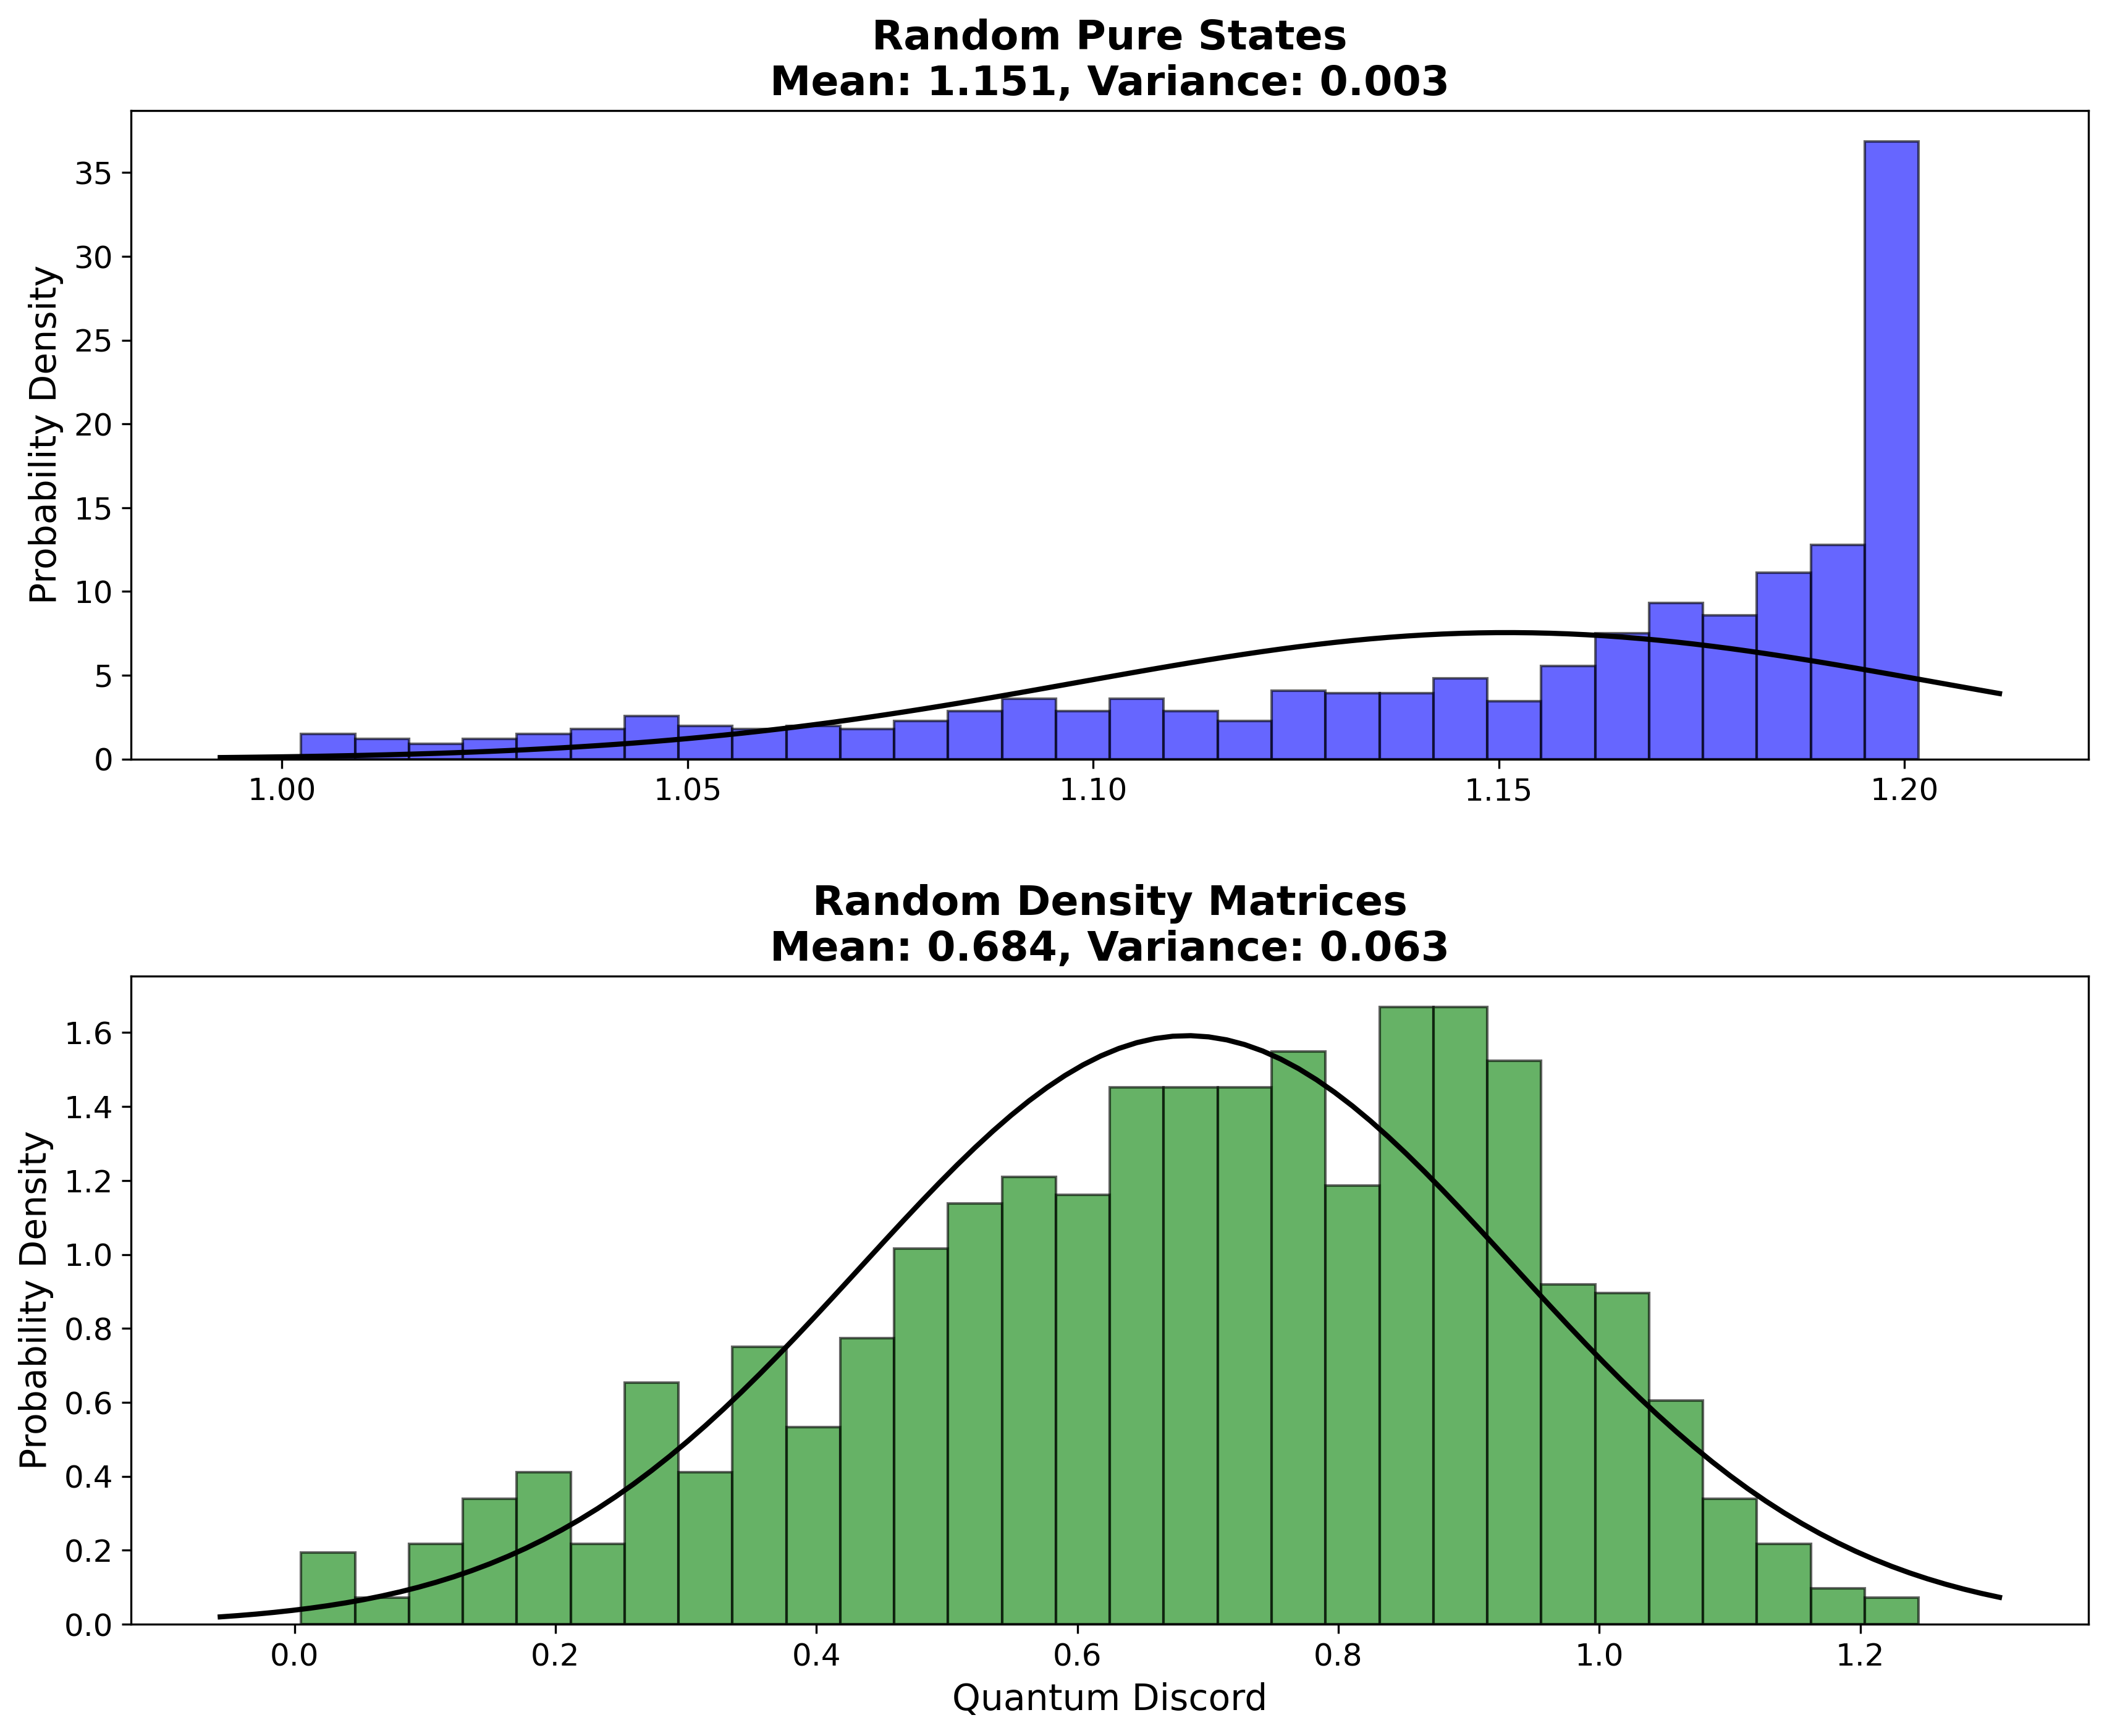

In [1]:
import numpy as np
from scipy.linalg import sqrtm, eigvals
from qutip import *
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.stats import unitary_group, norm

def entanglement_of_formation(concurrence):
    if concurrence <= 0:
        return 0
    elif concurrence >= 1:
        return 1
    h = lambda x: -x * np.log2(x + 1e-12) - (1 - x) * np.log2(1 - x + 1e-12)  # Binary entropy function
    sqrt_term = np.sqrt(1 - concurrence**2)
    return h((1 + max(0, sqrt_term)) / 2)  # Calculate entanglement of formation

def calculate_concurrence(rho):
    rho = rho.full().astype(np.complex128)
    try:
        R = sqrtm(sqrtm(rho) @ rho.conj().T @ sqrtm(rho))
        eigvals_R = np.sort(np.real(eigvals(R)))[::-1]
        return max(0, eigvals_R[0] - sum(eigvals_R[1:]))
    except ValueError as e:
        return np.nan

def quantum_discord(rho_AB):
    try:
        eigvals, eigvecs = rho_AB.eigenstates()
        ancilla_dim = 2
        psi_purified = sum(np.sqrt(max(0, eigvals[i])) * tensor(eigvecs[i], basis(ancilla_dim, 0)) for i in range(len(eigvals)))
        rho_AC = psi_purified.ptrace([0, 2])
        rho_B = rho_AB.ptrace([1])
        S_rho_B = entropy_vn(rho_B, base=2)
        S_rho_AB = entropy_vn(rho_AB, base=2)
        concurrence_rho_AC = calculate_concurrence(rho_AC)
        E_C = entanglement_of_formation(concurrence_rho_AC)
        return max(0, S_rho_B - S_rho_AB + E_C)
    except ValueError as e:
        return np.nan

# Generate 1000 random pure states and calculate their quantum discord
quantum_discord_pure = []
for _ in tqdm(range(1000), desc="Random Pure States"):
    psi = np.zeros(4)
    psi[0] = 1.
    random_psi = unitary_group.rvs(4) @ psi
    random_rho_pure = np.outer(random_psi, np.conjugate(random_psi))
    rho_pure_qobj = Qobj(random_rho_pure, dims=[[2, 2], [2, 2]])
    discord_pure = quantum_discord(rho_pure_qobj)
    if not np.isnan(discord_pure):
        quantum_discord_pure.append(discord_pure)

# Generate 1000 random rank-2 density matrices and calculate their quantum discord
quantum_discord_density = []
for _ in tqdm(range(1000), desc="Random Density Matrices"):
    gin = np.random.normal(size=(4, 2)) + 1j * np.random.normal(size=(4, 2))  # Generate a 4x2 matrix with Gaussian distribution
    gue = gin @ gin.conj().T  # Create a 4x4 Hermitian matrix
    gue = gue / np.trace(gue)
    random_rho_density = gue
    if np.abs(np.trace(random_rho_density) - 1) > 1.e-14:
        raise ValueError("Trace is not 1!")
    rho_density_qobj = Qobj(random_rho_density, dims=[[2, 2], [2, 2]])
    discord_density = quantum_discord(rho_density_qobj)
    if not np.isnan(discord_density):
        quantum_discord_density.append(discord_density)

# Calculate mean and variance
mean_discord_pure = np.mean(quantum_discord_pure)
var_discord_pure = np.var(quantum_discord_pure)
mean_discord_density = np.mean(quantum_discord_density)
var_discord_density = np.var(quantum_discord_density)

# Create histograms and overlay Gaussian distribution
fig, axs = plt.subplots(2, 1, figsize=(12, 10), dpi=300)

# Histogram for random pure states
axs[0].hist(quantum_discord_pure, bins=30, density=True, alpha=0.6, color='blue', edgecolor='black')
xmin, xmax = axs[0].get_xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mean_discord_pure, np.sqrt(var_discord_pure))
axs[0].plot(x, p, 'k', linewidth=2)
axs[0].set_title(f'Random Pure States\nMean: {mean_discord_pure:.3f}, Variance: {var_discord_pure:.3f}', fontsize=16, fontweight='bold')
axs[0].set_ylabel('Probability Density', fontsize=14)
axs[0].tick_params(axis='both', which='major', labelsize=12)
#axs[0].grid(True, linestyle='--', linewidth=0.5)

# Histogram for random density matrices
axs[1].hist(quantum_discord_density, bins=30, density=True, alpha=0.6, color='green', edgecolor='black')
xmin, xmax = axs[1].get_xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mean_discord_density, np.sqrt(var_discord_density))
axs[1].plot(x, p, 'k', linewidth=2)
axs[1].set_title(f'Random Density Matrices\nMean: {mean_discord_density:.3f}, Variance: {var_discord_density:.3f}', fontsize=16, fontweight='bold')
axs[1].set_xlabel('Quantum Discord', fontsize=14)
axs[1].set_ylabel('Probability Density', fontsize=14)
axs[1].tick_params(axis='both', which='major', labelsize=12)
#axs[1].grid(True, linestyle='--', linewidth=0.5)

plt.tight_layout(pad=3.0)
plt.show()
